In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1003)

datadir = Path('.').resolve().parents[0] / "data"
datadir

/home/mddevine/projects/ml-mushrooms/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


PosixPath('/home/mddevine/projects/ml-mushrooms/data')

# data prep

In [2]:
df = pd.read_csv(datadir / "processed" / "mushroom_final.csv")
print(f"{len(df)} observations.")
df.head()

8124 observations.


,class,cap_shape__x,cap_shape__b,cap_shape__s,cap_shape__f,cap_shape__k,cap_shape__c,cap_surface__s,cap_surface__y,cap_surface__f,...,population__v,population__y,population__c,habitat__u,habitat__g,habitat__m,habitat__d,habitat__p,habitat__w,habitat__l
0,p,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,e,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,e,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,p,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,e,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [3]:
# features == all columns except the class (our target)
features = df.columns[1:]
X, y = df[features], df['class']
features

Index(['cap_shape__x', 'cap_shape__b', 'cap_shape__s', 'cap_shape__f',
       'cap_shape__k', 'cap_shape__c', 'cap_surface__s', 'cap_surface__y',
       'cap_surface__f', 'cap_surface__g',
       ...
       'population__v', 'population__y', 'population__c', 'habitat__u',
       'habitat__g', 'habitat__m', 'habitat__d', 'habitat__p', 'habitat__w',
       'habitat__l'],
      dtype='object', length=117)

# Train and Evaluate

In [4]:
from collections import namedtuple
Experiment = namedtuple(
    'Experiment',
    ['k', 'train_index', 'test_index', 'clf', 'predictions', 'accuracy'])

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5, shuffle=True, random_state=1003)
all_experiments = {}
all_accuracies = []
for k, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf = RandomForestClassifier(n_jobs=2, random_state=1003)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    all_accuracies.append(acc)
    all_experiments[k] = Experiment(k, train_index, test_index, clf, predictions, acc)
    print(f"{k=}, {len(train_index)}, {len(test_index)} --> {acc=}")
    
print(f"average accuracy across runs = {round(sum(all_accuracies) / len(all_accuracies), 2)}")

k=0, 6499, 1625 --> acc=1.0
k=1, 6499, 1625 --> acc=1.0
k=2, 6499, 1625 --> acc=1.0
k=3, 6499, 1625 --> acc=1.0
k=4, 6500, 1624 --> acc=1.0
average accuracy across runs = 1.0


# review mismatches
of course there are none as we were 100% accurate

In [6]:
for k, exp in all_experiments.items():
    for i, (actual, pred) in enumerate(zip(y.loc[exp.test_index], exp.predictions)):
        if actual != pred:
            print(f"{k=}:{actual=} {pred=}, index={exp.test_index[i]}")

# feature importance

In [7]:
data = []
for k, exp in all_experiments.items():
    data.append(exp.clf.feature_importances_)
    
feat_imp_df = pd.DataFrame(data, columns=features)

# summarize feature importance across original features (rather than one hot encoded features)
# we added `__x` to each original feature during ohe, so we can just slice off the last 3 chars
orig_features = list(set([col[:-3] for col in feat_imp_df.columns]))
for f in orig_features:
    feat_imp_df[f] = (feat_imp_df
                      [[col for col in feat_imp_df.columns if col.startswith(f)]]
                      .sum(axis=1))

feat_imp_df = feat_imp_df[sorted(orig_features)]
feat_imp_df.head()

,bruised,cap_color,cap_shape,cap_surface,gill_attachment,gill_color,gill_size,gill_spacing,habitat,odor,...,ring_type,spore_print_color,stalk_color_above_ring,stalk_color_below_ring,stalk_root,stalk_shape,stalk_surface_above_ring,stalk_surface_below_ring,veil_color,veil_type
0,0.083777,0.014794,0.005171,0.014554,0.001816,0.069669,0.101999,0.032010,0.040409,0.200511,...,0.062679,0.079043,0.013096,0.018546,0.057034,0.034195,0.069758,0.050298,0.002439,0.0
1,0.077877,0.014376,0.004590,0.012154,0.000893,0.067335,0.094454,0.038909,0.041971,0.211071,...,0.071986,0.076376,0.012821,0.021034,0.057392,0.030122,0.065768,0.048280,0.001772,0.0
2,0.081521,0.013745,0.003662,0.009320,0.001798,0.064515,0.108157,0.031085,0.039944,0.201010,...,0.053236,0.087361,0.014120,0.024657,0.056468,0.031077,0.068883,0.053777,0.001667,0.0
3,0.082708,0.013272,0.004007,0.011038,0.001037,0.065574,0.103813,0.040323,0.037088,0.214682,...,0.058786,0.078435,0.009602,0.019652,0.051212,0.027566,0.075071,0.054503,0.002450,0.0
4,0.080167,0.015253,0.004674,0.013003,0.001388,0.067227,0.098318,0.031480,0.042803,0.199678,...,0.062948,0.078697,0.011974,0.023854,0.056704,0.035998,0.070259,0.050983,0.002663,0.0


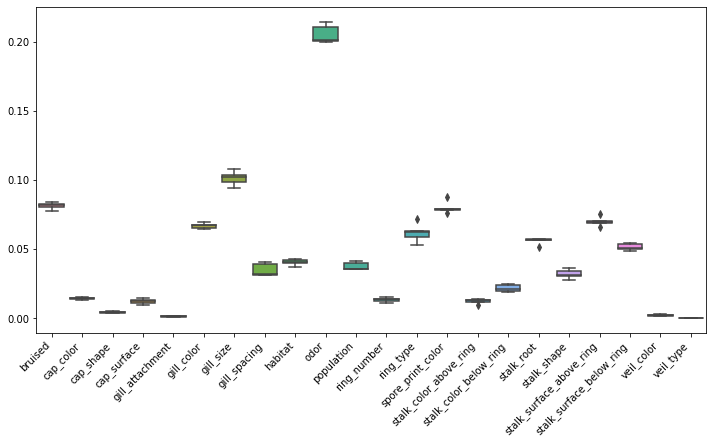

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
chart = sns.boxplot(data=feat_imp_df)    
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart;